In [1]:
import scvi
import os
import tempfile
import scanpy as sc
import scarches as sca
import seaborn as sns
import torch
import pandas as pd
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import skmisc

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [2]:
scvi.settings.seed = 42
torch.set_float32_matmul_precision('high')

[rank: 0] Seed set to 42


In [3]:
adata_tumour = sc.read("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_5_tumour_only/sce_tumour.h5ad")
adata_tumour

AnnData object with n_obs × n_vars = 16454 × 19463
    obs: 'bc_wells', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'doublet_score', 'predicted_doublets', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'low_lib_size', 'low_n_features', 'high_subsets_mito_percent', 'discard', 'discard_mito', 'discard_feature', 'discard_final', 'sizeFactor', 'leiden_individual', 'type', 'line'
    var: 'gene_id', 'gene_name', 'genome', 'gene_version', 'gene_source', 'gene_biotype'
    uns: 'X_name'
    obsm: 'X_scVI_MDE'
    layers: 'logcounts'

In [4]:
adata_full = adata_tumour.copy()

In [5]:
sc.pp.highly_variable_genes(
    adata = adata_tumour, 
    flavor = "seurat_v3",
    n_top_genes = 5000, 
    subset = True
)

In [6]:
# integration with scVI
scvi.model.SCVI.setup_anndata(
    adata = adata_tumour, 
    batch_key = "sample"
)
# create model
scvi_model = scvi.model.SCVI(
    adata = adata_tumour,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
# train model
# scvi.settings.dl_num_workers = 15
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 461/1000:  46%|████▌     | 461/1000 [06:45<07:54,  1.14it/s, v_num=1, train_loss_step=2.6e+3, train_loss_epoch=2.53e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2617.924. Signaling Trainer to stop.


In [7]:
# train_test_results = scvi_model.history["elbo_train"]
# train_test_results["elbo_validation"] = scvi_model.history["elbo_validation"]
# train_test_results.iloc[10:].plot(logy = True)  # exclude first 10 epochs
# plt.show()

In [8]:
SCVI_LATENT_KEY = "X_scVI"
adata_tumour.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [9]:
sc.pp.neighbors(
    adata = adata_tumour, 
    use_rep = SCVI_LATENT_KEY, 
    method = "gauss",
    n_neighbors = 15,
    n_pcs = 50,
    knn = False
)
# sc.tl.umap(
#     adata = adata, 
#     min_dist = 0.005
# )
sc.tl.leiden(
    adata_tumour,
    flavor = "igraph",
    # resolution = 1,
    # n_iterations = 10
)

In [10]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata_tumour.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata_tumour.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


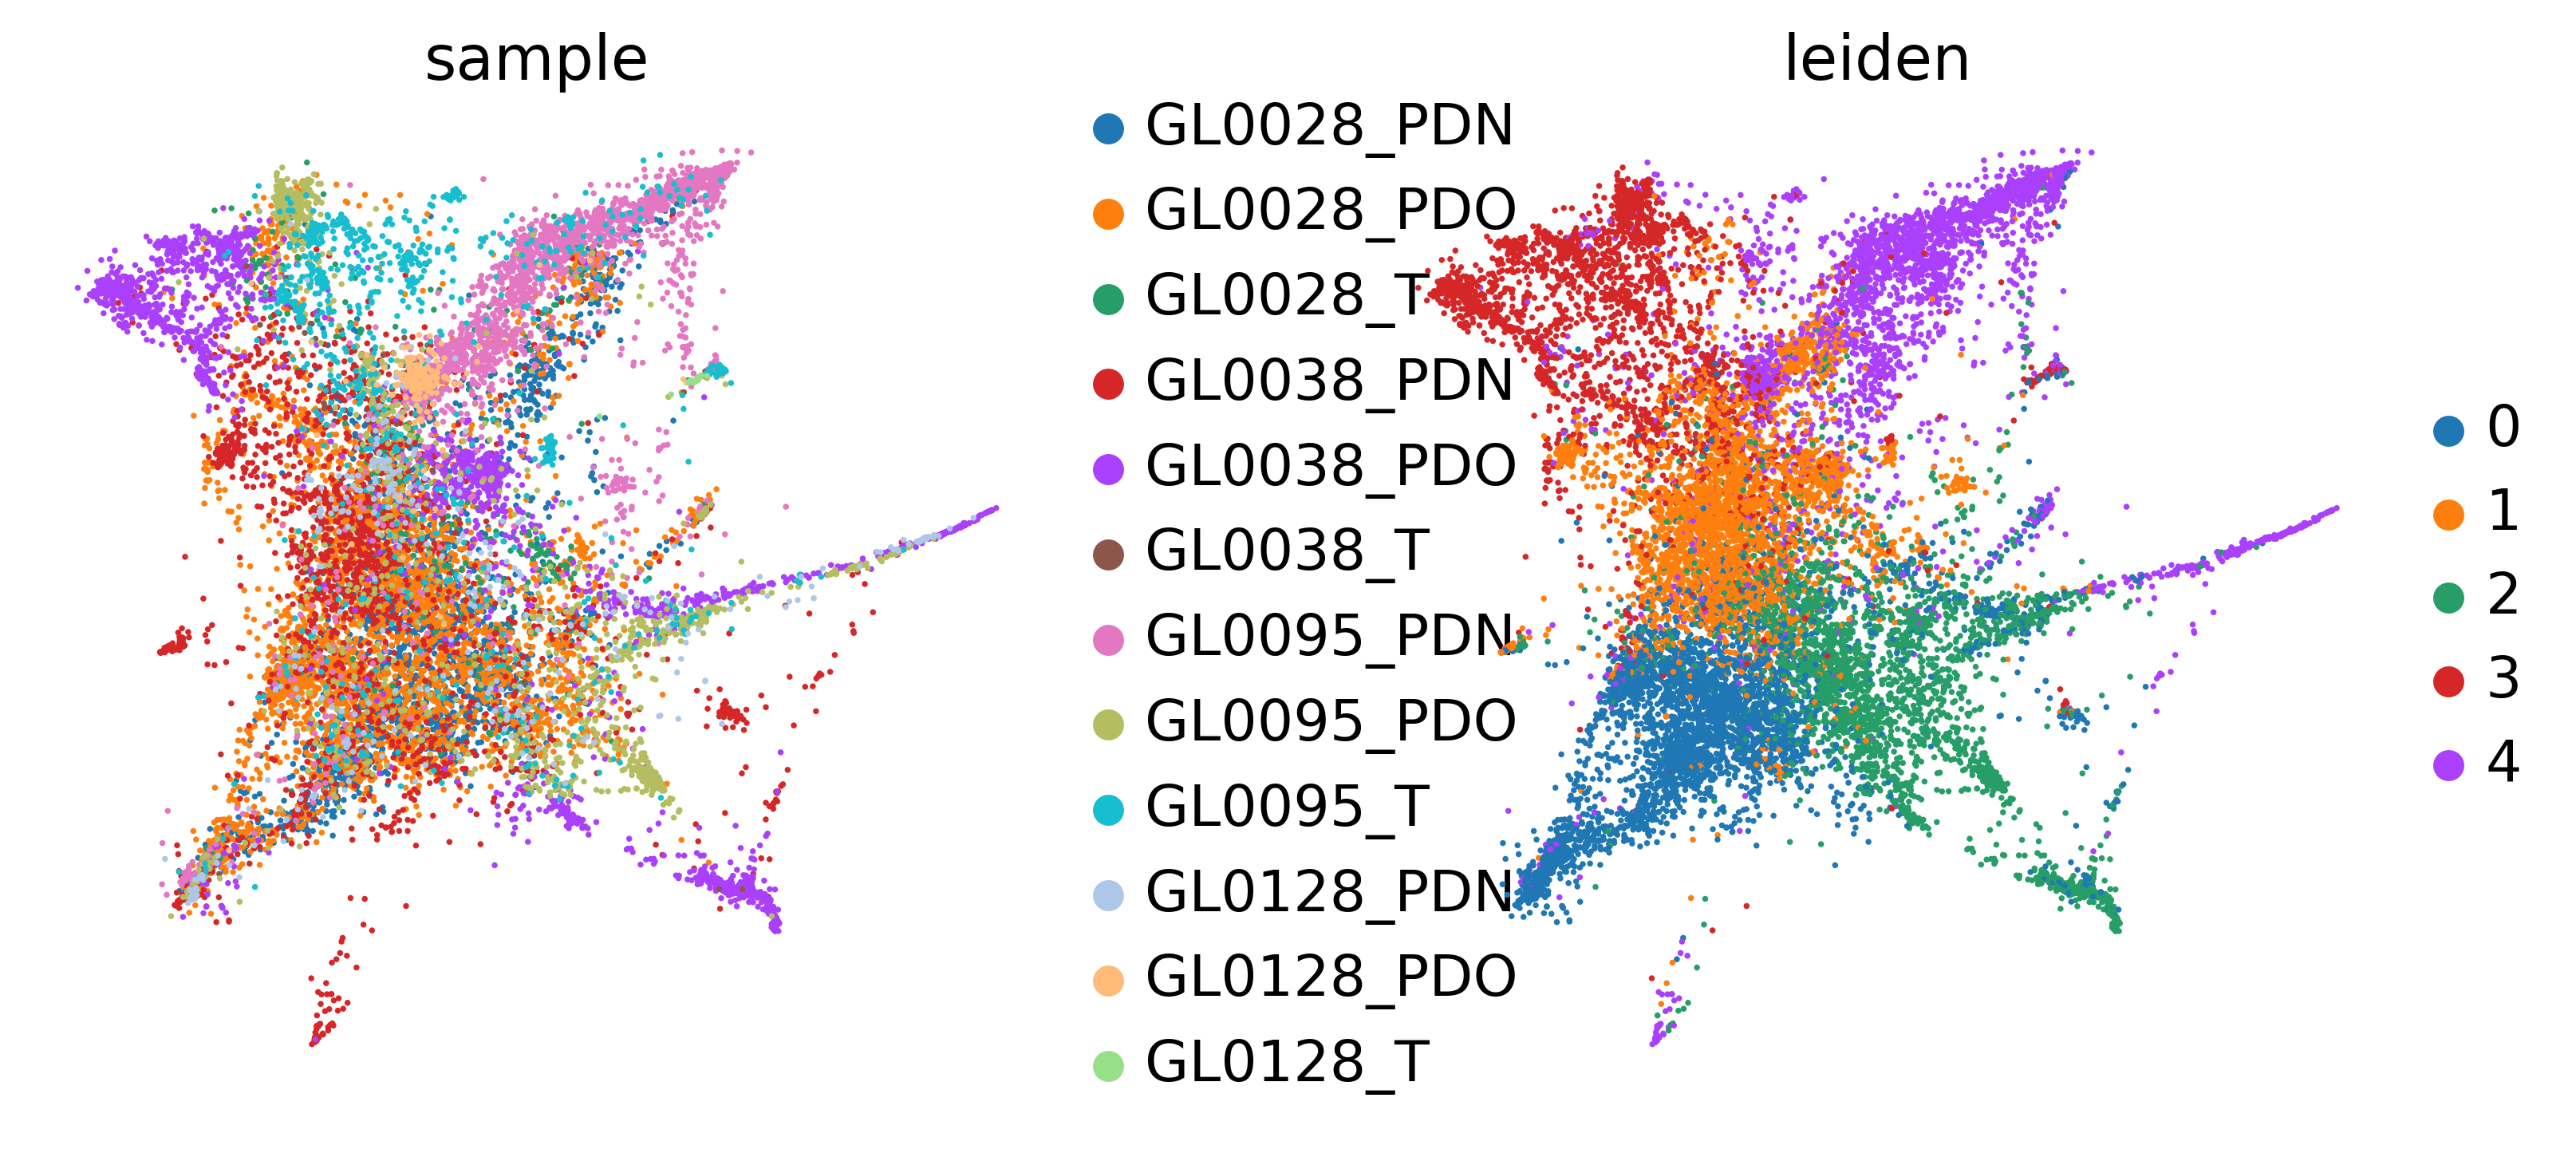

In [11]:
sc.pl.embedding(
    adata = adata_tumour,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

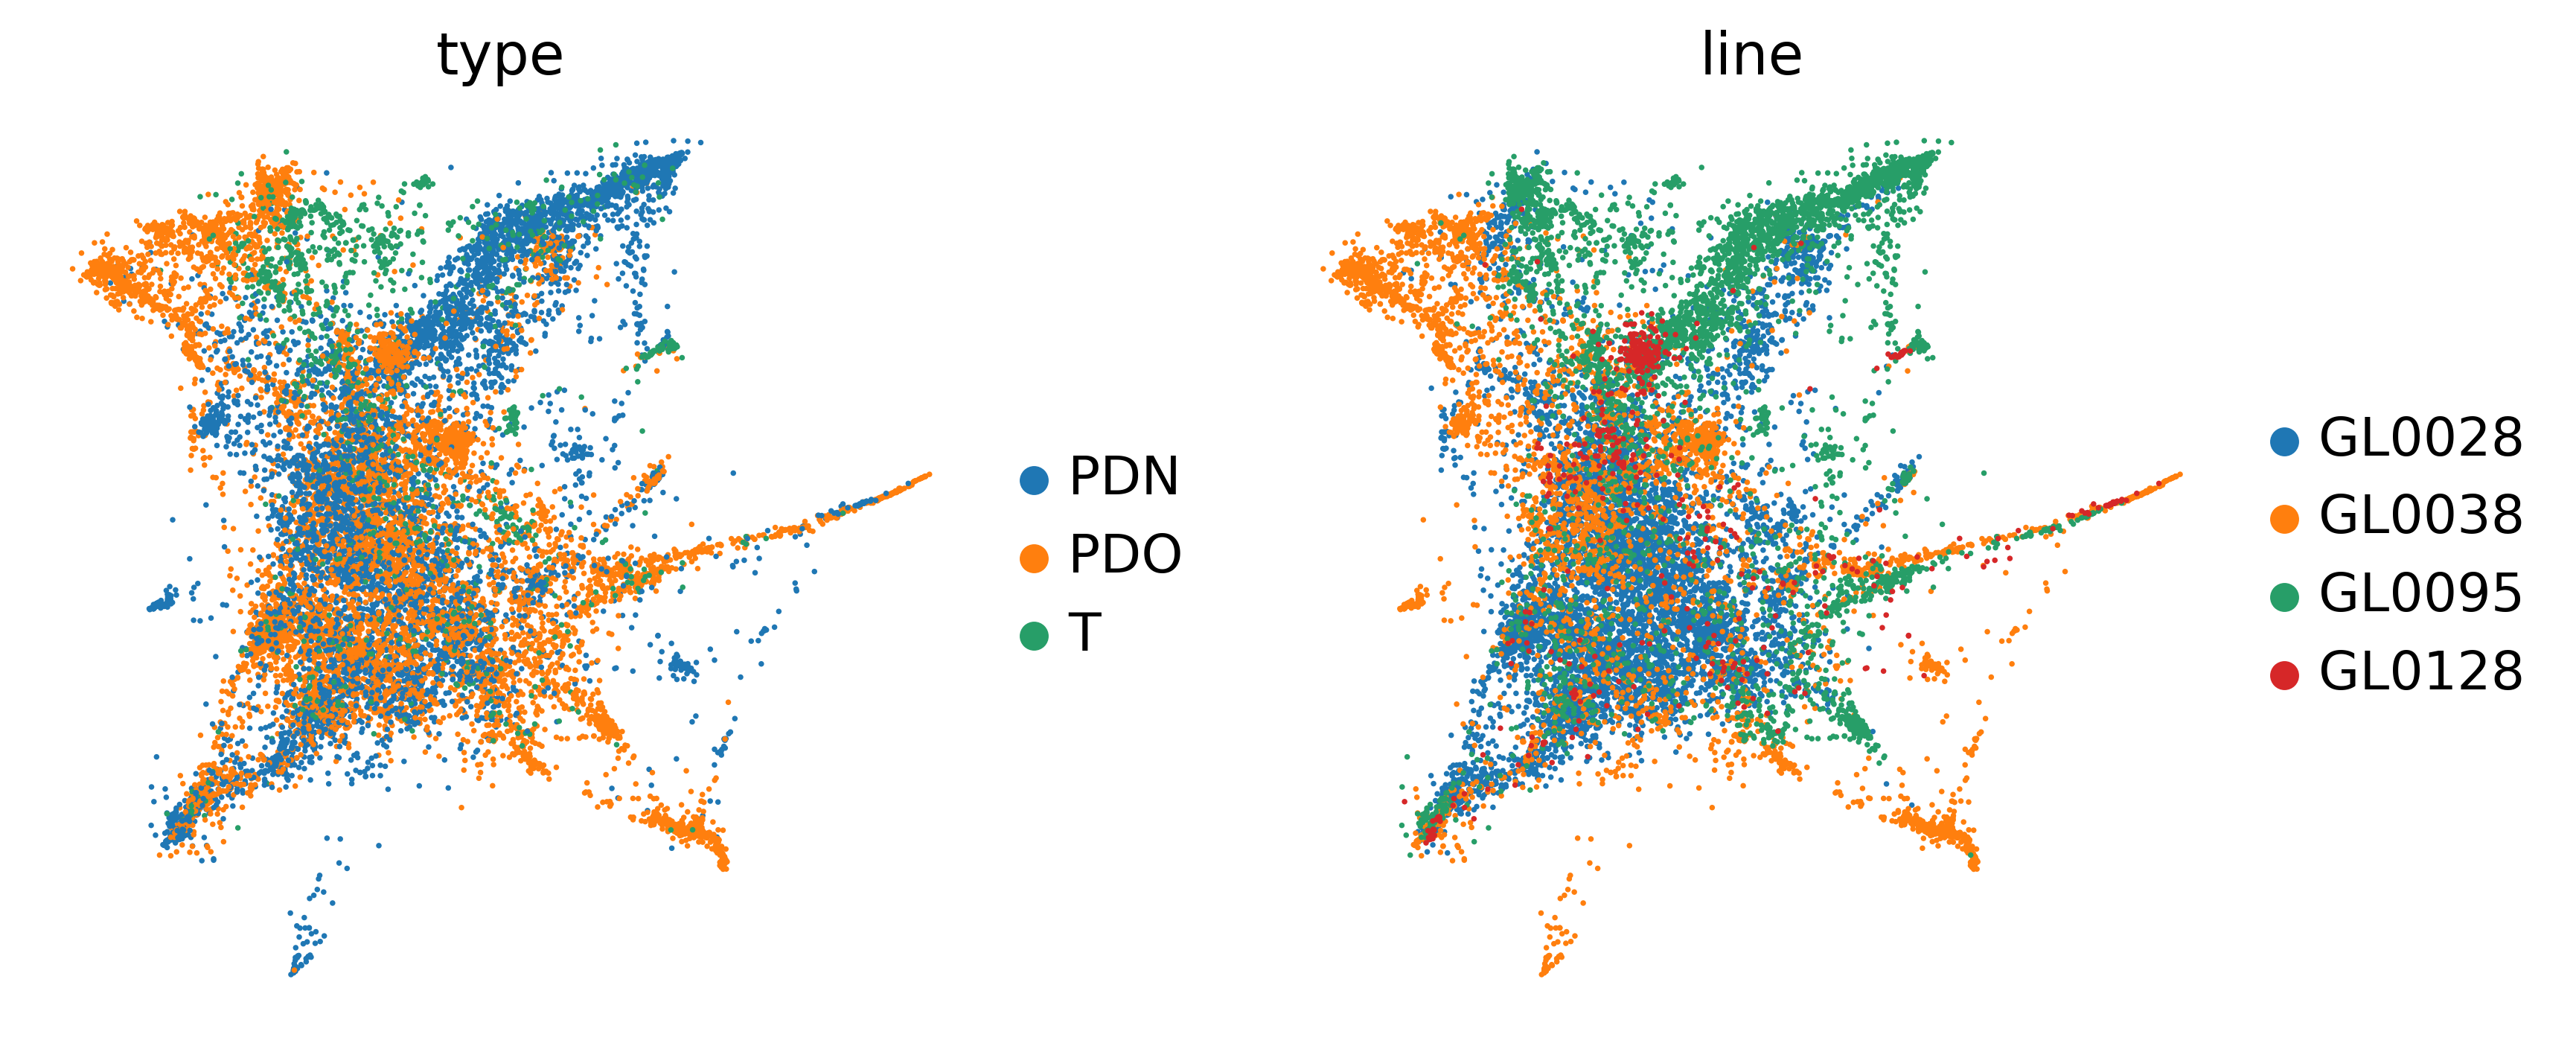

In [12]:
sc.pl.embedding(
    adata = adata_tumour,
    basis = SCVI_MDE_KEY,
    color = ["type", "line"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

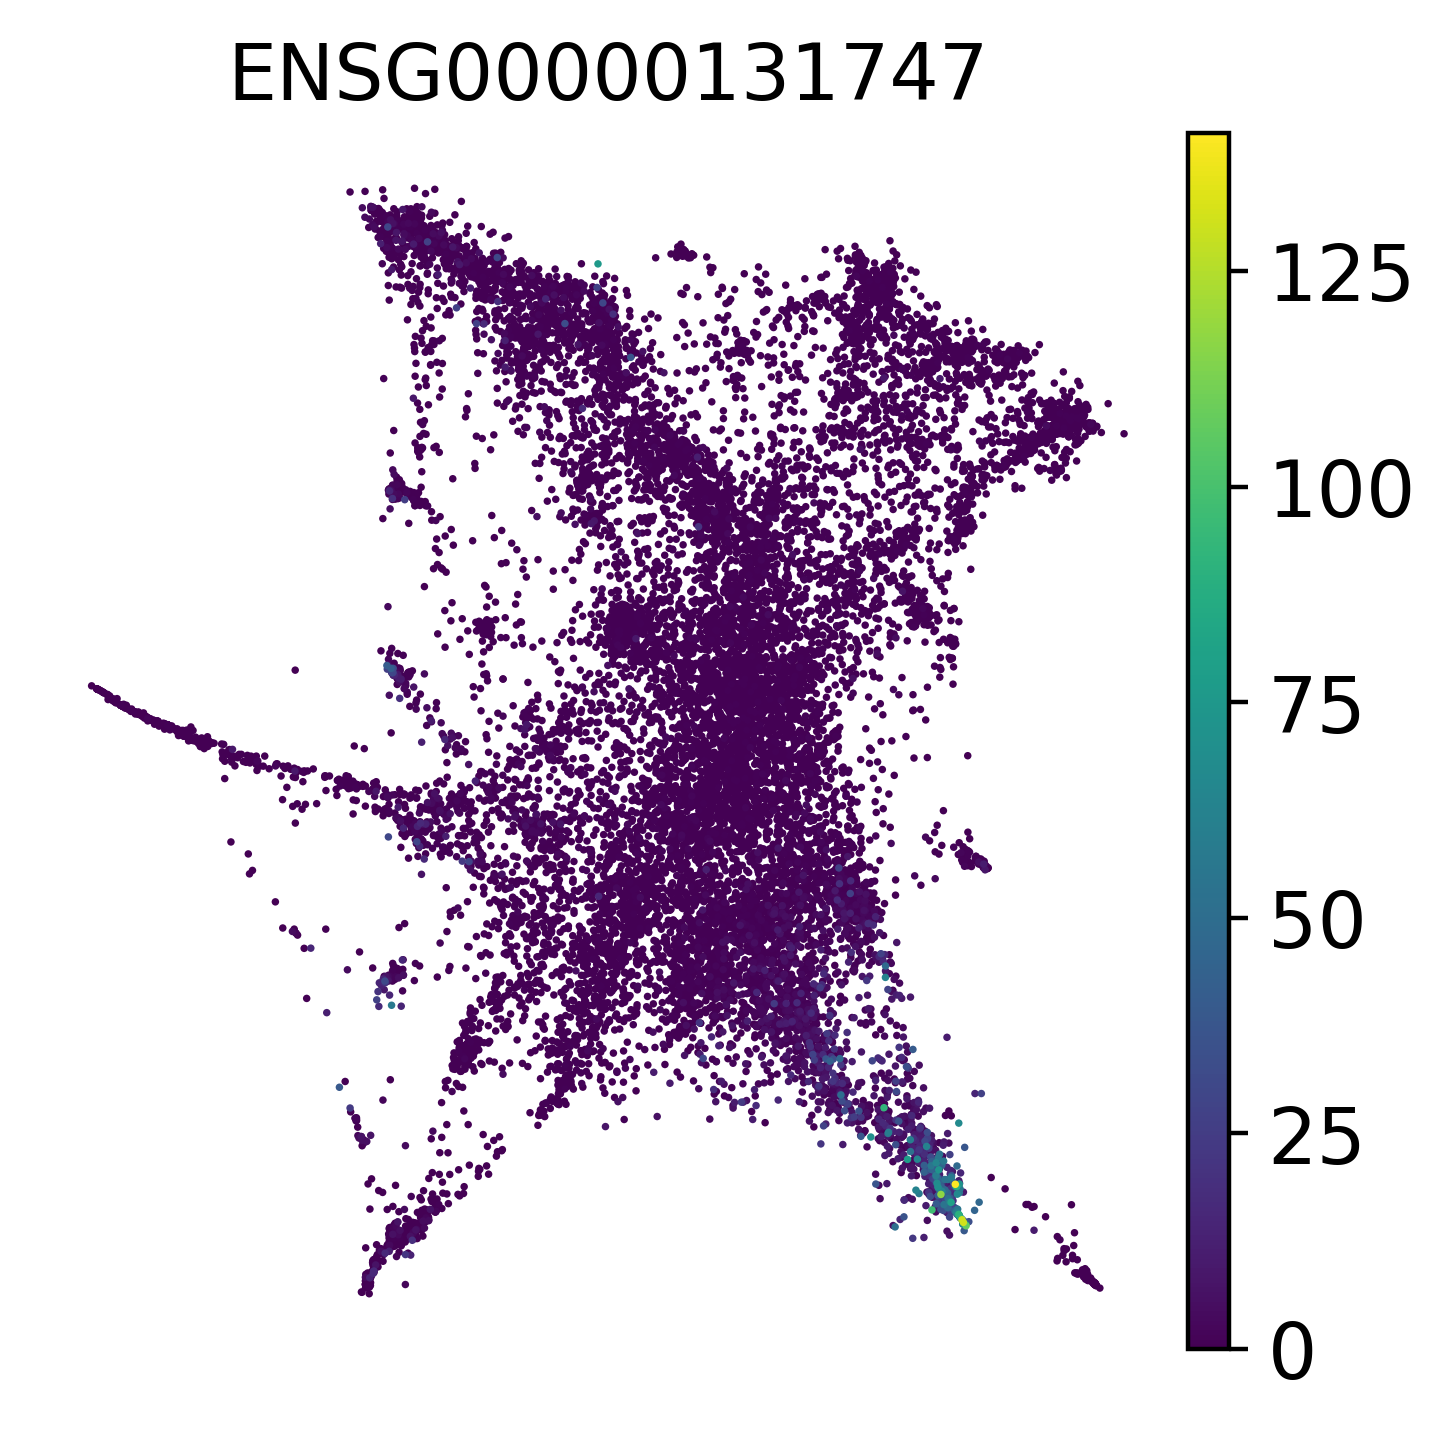

In [15]:
sc.pl.embedding(
    adata = adata_tumour,
    basis = SCVI_MDE_KEY,
    color = ["ENSG00000131747"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

In [13]:
import scipy as sp
con = adata_tumour.obsp["connectivities"]
dist = adata_tumour.obsp["distances"]

con = pd.DataFrame(con)
dist = pd.DataFrame(dist)

con.to_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_5_tumour_only/all_con.csv")
dist.to_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_5_tumour_only/all_dist.csv")

In [14]:
# df = adata_tumour.obs.loc[adata_tumour.obs["leiden"] == "21"]
# df.to_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/3_1_norm_labels/odd_cells.csv")

In [21]:
con = adata_tumour.obsp["connectivities"]
con.todense()

matrix([[1.  , 0.54, 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.54, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.57,
         0.  , 0.59, 0.62, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.58,
         0.59, 0.54, 0.56, 0.68],
        [0.  , 

In [15]:
adata_tumour.obs

bc_wells      sample species  gene_count  tscp_count  \
03_01_07__s1  03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0   
03_01_09__s1  03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0   
03_01_22__s1  03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0   
03_01_25__s1  03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0   
03_01_28__s1  03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0   
...                    ...         ...     ...         ...         ...   
10_67_90__s2  10_67_90__s2    GL0128_T    hg38       699.0       749.0   
10_69_55__s2  10_69_55__s2    GL0128_T    hg38       791.0       859.0   
10_78_55__s2  10_78_55__s2    GL0128_T    hg38       789.0       847.0   
10_89_66__s2  10_89_66__s2    GL0128_T    hg38      1487.0      1678.0   
10_92_72__s2  10_92_72__s2    GL0128_T    hg38       659.0       703.0   

              mread_count  bc1_wind  bc2_wind  bc3_wind bc1_well  ...  \
03_01_07__s1       7505.0       3.0       1.0       7.0       A3  ...   
03_01_09__s1      21724.0       3.0       1.0       9.0       A3  ...   
03_01_22__s1       8093.0       3.0       1.0      22.0       A3  ...   
03_01_25__s1      10742.0       3.0       1.0      25.0       A3  ...   
03_01_28__s1       7619.0       3.0       1.0      28.0       A3  ...   
...                   ...       ...       ...       ...      ...  ...   
10_67_90__s2       1195.0      10.0      67.0      90.0      A10  ...   
10_69_55__s2       1350.0      10.0      69.0      55.0      A10  ...   
10_78_55__s2       1389.0      10.0      78.0      55.0      A10  ...   
10_89_66__s2       2754.0      10.0      89.0      66.0      A10  ...   
10_92_72__s2       1157.0      10.0      92.0      72.0      A10  ...   

             discard_mito discard_feature  discard_final  sizeFactor  \
03_01_07__s1        False           False          False    0.771396   
03_01_09__s1        False           False          False    2.158509   
03_01_22__s1        False           False          False    0.794660   
03_01_25__s1        False           False          False    1.048819   
03_01_28__s1        False           False          False    0.778393   
...                   ...             ...            ...         ...   
10_67_90__s2        False           False          False    0.587101   
10_69_55__s2        False           False          False    0.672076   
10_78_55__s2        False           False          False    0.656626   
10_89_66__s2        False           False          False    1.302216   
10_92_72__s2        False           False          False    0.545165   

              leiden_individual  type    line  _scvi_batch  _scvi_labels  \
03_01_07__s1                  1   PDN  GL0028            0             0   
03_01_09__s1                  1   PDN  GL0028            0             0   
03_01_22__s1                  1   PDN  GL0028            0             0   
03_01_25__s1                  2   PDN  GL0028            0             0   
03_01_28__s1                  3   PDN  GL0028            0             0   
...                         ...   ...     ...          ...           ...   
10_67_90__s2                  1     T  GL0128           11             0   
10_69_55__s2                  1     T  GL0128           11             0   
10_78_55__s2                  1     T  GL0128           11             0   
10_89_66__s2                  1     T  GL0128           11             0   
10_92_72__s2                  1     T  GL0128           11             0   

              leiden  
03_01_07__s1       0  
03_01_09__s1       0  
03_01_22__s1       3  
03_01_25__s1       0  
03_01_28__s1       3  
...              ...  
10_67_90__s2      16  
10_69_55__s2      16  
10_78_55__s2      16  
10_89_66__s2      16  
10_92_72__s2      16  

[16454 rows x 34 columns]

In [101]:
adata_tumour.write_h5ad("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/tumour_only.h5ad")

In [90]:
pdn_index = (adata_tumour.obs["type"] == "PDN")
pdo_index = (adata_tumour.obs["type"] == "PDO")
t_index = (adata_tumour.obs["type"] == "T")

In [97]:
res_pdn_t = scvi_model.differential_expression(
    adata = adata_tumour, 
    idx1 = pdn_index,
    idx2 = t_index,
    weights = "uniform",
    # batch_correction = True
)
res_pdo_t = scvi_model.differential_expression(
    adata = adata_tumour, 
    idx1 = pdo_index,
    idx2 = t_index,
    weights = "uniform",
    # batch_correction = True
)

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


In [98]:
res_pdn_t

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
ENSG00000096060    0.9978        0.0022      6.117091  0.000142  0.002547   
ENSG00000144681    0.9976        0.0024      6.029880  0.000005  0.000336   
ENSG00000215018    0.9974        0.0026      5.949637  0.000057  0.001667   
ENSG00000111640    0.9964        0.0036      5.623212  0.001381  0.000080   
ENSG00000109906    0.9962        0.0038      5.568944  0.000119  0.001828   
...                   ...           ...           ...       ...       ...   
ENSG00000165338    0.7456        0.2544      1.075281  0.000282  0.000214   
ENSG00000122218    0.7452        0.2548      1.073174  0.000902  0.000507   
ENSG00000134108    0.7382        0.2618      1.036634  0.000327  0.000234   
ENSG00000156931    0.7284        0.2716      0.986520  0.000592  0.000562   
ENSG00000148737    0.6990        0.3010      0.842540  0.000446  0.000494   

                 pseudocounts  delta  lfc_mean  lfc_median   lfc_std  \
ENSG00000096060           0.0   0.25 -4.067869   -4.118086  1.150949   
ENSG00000144681           0.0   0.25 -6.424786   -6.550266  2.100548   
ENSG00000215018           0.0   0.25 -4.850124   -4.877947  1.696632   
ENSG00000111640           0.0   0.25  4.103245    4.184738  1.393779   
ENSG00000109906           0.0   0.25 -4.203661   -4.215885  1.243600   
...                       ...    ...       ...         ...       ...   
ENSG00000165338           0.0   0.25  0.370644    0.374764  0.674657   
ENSG00000122218           0.0   0.25  0.492785    0.207426  1.176625   
ENSG00000134108           0.0   0.25  0.157946   -0.019923  1.163804   
ENSG00000156931           0.0   0.25  0.001962   -0.023624  0.889969   
ENSG00000148737           0.0   0.25 -0.114386   -0.085738  0.693231   

                   lfc_min   lfc_max  raw_mean1  raw_mean2  \
ENSG00000096060  -8.169174  0.816005   0.397899  10.642912   
ENSG00000144681 -13.054487  3.924509   0.005322   0.629744   
ENSG00000215018 -10.495535  1.967763   0.174790   7.353989   
ENSG00000111640  -1.583052  8.093676   4.413165   0.223083   
ENSG00000109906  -8.304602  1.440526   0.334314   7.501162   
...                    ...       ...        ...        ...   
ENSG00000165338  -2.077072  2.946556   0.956162   0.784663   
ENSG00000122218  -2.853088  4.476057   3.130952   1.790085   
ENSG00000134108  -4.300673  4.659360   1.015546   0.906274   
ENSG00000156931  -3.904366  3.697346   2.069328   1.927963   
ENSG00000148737  -3.198879  2.111345   1.548179   1.780015   

                 non_zeros_proportion1  non_zeros_proportion2  \
ENSG00000096060               0.223810               0.828040   
ENSG00000144681               0.004482               0.227730   
ENSG00000215018               0.102941               0.690163   
ENSG00000111640               0.775210               0.181255   
ENSG00000109906               0.164286               0.839659   
...                                ...                    ...   
ENSG00000165338               0.437675               0.384198   
ENSG00000122218               0.702241               0.673122   
ENSG00000134108               0.433754               0.450813   
ENSG00000156931               0.620728               0.663052   
ENSG00000148737               0.542297               0.593338   

                 raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  
ENSG00000096060              1.163222             25.004285            True  
ENSG00000144681              0.024561              1.815698            True  
ENSG00000215018              0.536258             17.267943            True  
ENSG00000111640             13.724006              0.814394            True  
ENSG00000109906              0.989771             19.806966            True  
...                               ...                   ...             ...  
ENSG00000165338              2.799409              1.987214           False  
ENSG00000122218              9.811265              5.563122           False  

In [99]:
res_pdo_t

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
ENSG00000109906    1.0000        0.0000     18.420681  0.000098  0.001841   
ENSG00000096060    0.9972        0.0028      5.875328  0.000167  0.002581   
ENSG00000115112    0.9962        0.0038      5.568944  0.000007  0.000185   
ENSG00000154262    0.9896        0.0104      4.555494  0.000005  0.000073   
ENSG00000162511    0.9892        0.0108      4.517349  0.000001  0.000040   
...                   ...           ...           ...       ...       ...   
ENSG00000178950    0.6734        0.3266      0.723603  0.000265  0.000262   
ENSG00000112699    0.6650        0.3350      0.685656  0.000574  0.000538   
ENSG00000162642    0.6604        0.3396      0.665077  0.000129  0.000143   
ENSG00000100578    0.6502        0.3498      0.619918  0.000351  0.000333   
ENSG00000134108    0.6496        0.3504      0.617281  0.000206  0.000237   

                 pseudocounts  delta  lfc_mean  lfc_median   lfc_std  \
ENSG00000109906           0.0   0.25 -4.345699   -4.418170  1.043077   
ENSG00000096060           0.0   0.25 -3.835263   -3.854608  1.148100   
ENSG00000115112           0.0   0.25 -5.441936   -5.541282  2.183750   
ENSG00000154262           0.0   0.25 -4.037991   -4.083115  2.017738   
ENSG00000162511           0.0   0.25 -4.575726   -4.496052  2.399300   
...                       ...    ...       ...         ...       ...   
ENSG00000178950           0.0   0.25  0.046170    0.087488  0.604102   
ENSG00000112699           0.0   0.25  0.102395    0.073729  0.580952   
ENSG00000162642           0.0   0.25 -0.103179   -0.073042  0.623993   
ENSG00000100578           0.0   0.25  0.024512   -0.001684  0.668859   
ENSG00000134108           0.0   0.25 -0.090112   -0.023927  0.684982   

                   lfc_min   lfc_max  raw_mean1  raw_mean2  \
ENSG00000109906  -7.739316  0.777503   0.187960   7.501162   
ENSG00000096060  -8.109804  0.942345   0.396236  10.642912   
ENSG00000115112 -12.491527  3.453260   0.001745   0.605732   
ENSG00000154262 -10.138982  4.597589   0.006481   0.185128   
ENSG00000162511 -15.029564  3.673502   0.000997   0.076685   
...                    ...       ...        ...        ...   
ENSG00000178950  -3.171214  2.578816   0.756450   0.886135   
ENSG00000112699  -1.648842  2.768664   1.538826   1.917893   
ENSG00000162642  -2.656081  2.432041   0.354107   0.479473   
ENSG00000100578  -3.564169  3.269169   1.019070   1.225407   
ENSG00000134108  -3.901450  2.246433   0.643774   0.906274   

                 non_zeros_proportion1  non_zeros_proportion2  \
ENSG00000109906               0.105447               0.839659   
ENSG00000096060               0.221987               0.828040   
ENSG00000115112               0.001620               0.237026   
ENSG00000154262               0.005983               0.109218   
ENSG00000162511               0.000997               0.035631   
...                                ...                    ...   
ENSG00000178950               0.429141               0.493416   
ENSG00000112699               0.523370               0.573974   
ENSG00000162642               0.259005               0.321456   
ENSG00000100578               0.456812               0.538342   
ENSG00000134108               0.383148               0.450813   

                 raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  
ENSG00000109906              0.652243             19.806966            True  
ENSG00000096060              1.361518             25.004285            True  
ENSG00000115112              0.005732              1.219577            True  
ENSG00000154262              0.027350              0.538261            True  
ENSG00000162511              0.005794              0.206594            True  
...                               ...                   ...             ...  
ENSG00000178950              2.583475              2.737419           False  
ENSG00000112699              5.235604              5.061183           False  

In [100]:
res_pdn_t.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/pdn_t.csv")
res_pdo_t.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/pdo_t.csv")

In [25]:
pred_labels = pd.read_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/singler_anno.csv")
pred_labels.set_index("bc_wells")

labels
bc_wells                 
03_01_07__s1        Oligo
03_01_09__s1   Unassigned
03_01_22__s1   Unassigned
03_01_25__s1  Mesenchymal
03_01_28__s1        Astro
...                   ...
10_67_90__s2        Astro
10_69_55__s2        Astro
10_78_55__s2        Astro
10_89_66__s2   Unassigned
10_92_72__s2   Progenitor

[16454 rows x 1 columns]

In [24]:
df = adata_tumour.obs
df

bc_wells      sample species  gene_count  tscp_count  \
03_01_07__s1  03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0   
03_01_09__s1  03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0   
03_01_22__s1  03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0   
03_01_25__s1  03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0   
03_01_28__s1  03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0   
...                    ...         ...     ...         ...         ...   
10_67_90__s2  10_67_90__s2    GL0128_T    hg38       699.0       749.0   
10_69_55__s2  10_69_55__s2    GL0128_T    hg38       791.0       859.0   
10_78_55__s2  10_78_55__s2    GL0128_T    hg38       789.0       847.0   
10_89_66__s2  10_89_66__s2    GL0128_T    hg38      1487.0      1678.0   
10_92_72__s2  10_92_72__s2    GL0128_T    hg38       659.0       703.0   

              mread_count  bc1_wind  bc2_wind  bc3_wind bc1_well  ...  \
03_01_07__s1       7505.0       3.0       1.0       7.0       A3  ...   
03_01_09__s1      21724.0       3.0       1.0       9.0       A3  ...   
03_01_22__s1       8093.0       3.0       1.0      22.0       A3  ...   
03_01_25__s1      10742.0       3.0       1.0      25.0       A3  ...   
03_01_28__s1       7619.0       3.0       1.0      28.0       A3  ...   
...                   ...       ...       ...       ...      ...  ...   
10_67_90__s2       1195.0      10.0      67.0      90.0      A10  ...   
10_69_55__s2       1350.0      10.0      69.0      55.0      A10  ...   
10_78_55__s2       1389.0      10.0      78.0      55.0      A10  ...   
10_89_66__s2       2754.0      10.0      89.0      66.0      A10  ...   
10_92_72__s2       1157.0      10.0      92.0      72.0      A10  ...   

             discard_mito discard_feature  discard_final  sizeFactor  \
03_01_07__s1        False           False          False    0.771396   
03_01_09__s1        False           False          False    2.158509   
03_01_22__s1        False           False          False    0.794660   
03_01_25__s1        False           False          False    1.048819   
03_01_28__s1        False           False          False    0.778393   
...                   ...             ...            ...         ...   
10_67_90__s2        False           False          False    0.587101   
10_69_55__s2        False           False          False    0.672076   
10_78_55__s2        False           False          False    0.656626   
10_89_66__s2        False           False          False    1.302216   
10_92_72__s2        False           False          False    0.545165   

              leiden_individual  type    line  _scvi_batch  _scvi_labels  \
03_01_07__s1                  1   PDN  GL0028            0             0   
03_01_09__s1                  1   PDN  GL0028            0             0   
03_01_22__s1                  1   PDN  GL0028            0             0   
03_01_25__s1                  2   PDN  GL0028            0             0   
03_01_28__s1                  3   PDN  GL0028            0             0   
...                         ...   ...     ...          ...           ...   
10_67_90__s2                  1     T  GL0128           11             0   
10_69_55__s2                  1     T  GL0128           11             0   
10_78_55__s2                  1     T  GL0128           11             0   
10_89_66__s2                  1     T  GL0128           11             0   
10_92_72__s2                  1     T  GL0128           11             0   

              leiden  
03_01_07__s1       0  
03_01_09__s1       0  
03_01_22__s1       3  
03_01_25__s1       0  
03_01_28__s1       3  
...              ...  
10_67_90__s2      16  
10_69_55__s2      16  
10_78_55__s2      16  
10_89_66__s2      16  
10_92_72__s2      16  

[16454 rows x 34 columns]

In [29]:
df2 = df.merge(pred_labels, left_on='bc_wells', right_on='bc_wells')

In [40]:
df2

bc_wells      sample species  gene_count  tscp_count  mread_count  \
0      03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0       7505.0   
1      03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0      21724.0   
2      03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0       8093.0   
3      03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0      10742.0   
4      03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0       7619.0   
...             ...         ...     ...         ...         ...          ...   
16449  10_67_90__s2    GL0128_T    hg38       699.0       749.0       1195.0   
16450  10_69_55__s2    GL0128_T    hg38       791.0       859.0       1350.0   
16451  10_78_55__s2    GL0128_T    hg38       789.0       847.0       1389.0   
16452  10_89_66__s2    GL0128_T    hg38      1487.0      1678.0       2754.0   
16453  10_92_72__s2    GL0128_T    hg38       659.0       703.0       1157.0   

       bc1_wind  bc2_wind  bc3_wind bc1_well  ... discard_feature  \
0           3.0       1.0       7.0       A3  ...           False   
1           3.0       1.0       9.0       A3  ...           False   
2           3.0       1.0      22.0       A3  ...           False   
3           3.0       1.0      25.0       A3  ...           False   
4           3.0       1.0      28.0       A3  ...           False   
...         ...       ...       ...      ...  ...             ...   
16449      10.0      67.0      90.0      A10  ...           False   
16450      10.0      69.0      55.0      A10  ...           False   
16451      10.0      78.0      55.0      A10  ...           False   
16452      10.0      89.0      66.0      A10  ...           False   
16453      10.0      92.0      72.0      A10  ...           False   

      discard_final  sizeFactor  leiden_individual  type    line  _scvi_batch  \
0             False    0.771396                  1   PDN  GL0028            0   
1             False    2.158509                  1   PDN  GL0028            0   
2             False    0.794660                  1   PDN  GL0028            0   
3             False    1.048819                  2   PDN  GL0028            0   
4             False    0.778393                  3   PDN  GL0028            0   
...             ...         ...                ...   ...     ...          ...   
16449         False    0.587101                  1     T  GL0128           11   
16450         False    0.672076                  1     T  GL0128           11   
16451         False    0.656626                  1     T  GL0128           11   
16452         False    1.302216                  1     T  GL0128           11   
16453         False    0.545165                  1     T  GL0128           11   

       _scvi_labels  leiden       labels  
0                 0       0        Oligo  
1                 0       0   Unassigned  
2                 0       3   Unassigned  
3                 0       0  Mesenchymal  
4                 0       3        Astro  
...             ...     ...          ...  
16449             0      16        Astro  
16450             0      16        Astro  
16451             0      16        Astro  
16452             0      16   Unassigned  
16453             0      16   Progenitor  

[16454 rows x 35 columns]

In [41]:
df2["labels"].unique()

array(['Oligo', 'Unassigned', 'Mesenchymal', 'Astro', 'Neuronal',
       'Progenitor'], dtype=object)

In [47]:
per_anno_pdn_tis = pd.DataFrame()

for x in df2["line"].unique():
    for y in df2["labels"].unique():

        idx_1 = (df2["line"] == x) & (df2["labels"] == y) & (df2["type"] == "PDN")
        idx_2 = (df2["line"] == x) & (df2["labels"] == y) & (df2["type"] == "T")
        
        if not any(idx_1) or not any(idx_2):
            continue
    
        res_pdn_tis = scvi_model.differential_expression(
            adata = adata_tumour, 
            idx1 = idx_1,
            idx2 = idx_2,
            filter_outlier_cells = False,
            batch_correction = False
        )

        res_pdn_tis.insert(0, "line", x)
        res_pdn_tis.insert(0, "labels", y)
    
        per_anno_pdn_tis = pd.concat([per_anno_pdn_tis, res_pdn_tis])

per_anno_pdn_tis.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/pdn_t_per_sample_per_anno.csv")

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


In [48]:
per_anno_pdo_tis = pd.DataFrame()

for x in df2["line"].unique():
    for y in df2["labels"].unique():

        idx_1 = (df2["line"] == x) & (df2["labels"] == y) & (df2["type"] == "PDO")
        idx_2 = (df2["line"] == x) & (df2["labels"] == y) & (df2["type"] == "T")
        
        if not any(idx_1) or not any(idx_2):
            continue
    
        res_pdo_tis = scvi_model.differential_expression(
            adata = adata_tumour, 
            idx1 = idx_1,
            idx2 = idx_2,
            filter_outlier_cells = False,
            batch_correction = False
        )

        res_pdo_tis.insert(0, "line", x)
        res_pdo_tis.insert(0, "labels", y)
    
        per_anno_pdo_tis = pd.concat([per_anno_pdo_tis, res_pdo_tis])

per_anno_pdo_tis.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/pdo_t_per_sample_per_anno.csv")

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


In [51]:
per_anno_overall = pd.DataFrame()

for x in df2["labels"].unique():

    (df2["labels"] == x) & (df2["type"] == "PDN")
    (df2["labels"] == x) & (df2["type"] == "T")
        
    if not any(idx_1) or not any(idx_2):
        continue
    
    res_pdn_tis = scvi_model.differential_expression(
        adata = adata_tumour, 
        idx1 = idx_1,
        idx2 = idx_2,
        filter_outlier_cells = True,
        batch_correction = False
    )

    res_pdn_tis.insert(0, "labels", x)
    res_pdn_tis.insert(0, "compar", "pdn_t")

    per_anno_overall = pd.concat([per_anno_overall, res_pdn_tis])

for x in df2["labels"].unique():

    (df2["labels"] == x) & (df2["type"] == "PDO")
    (df2["labels"] == x) & (df2["type"] == "T")
        
    if not any(idx_1) or not any(idx_2):
        continue
    
    res_pdo_tis = scvi_model.differential_expression(
        adata = adata_tumour, 
        idx1 = idx_1,
        idx2 = idx_2,
        filter_outlier_cells = True,
        batch_correction = False
    )

    res_pdo_tis.insert(0, "labels", x)
    res_pdo_tis.insert(0, "compar", "pdo_t")

    per_anno_overall = pd.concat([per_anno_overall, res_pdo_tis])

for x in df2["labels"].unique():

    (df2["labels"] == x) & (df2["type"] == "PDN")
    (df2["labels"] == x) & (df2["type"] == "PDO")
        
    if not any(idx_1) or not any(idx_2):
        continue
    
    res_pdn_pdo = scvi_model.differential_expression(
        adata = adata_tumour, 
        idx1 = idx_1,
        idx2 = idx_2,
        filter_outlier_cells = True,
        batch_correction = False
    )

    res_pdn_pdo.insert(0, "labels", x)
    res_pdn_pdo.insert(0, "compar", "pdn_pdo")

    per_anno_overall = pd.concat([per_anno_overall, res_pdn_pdo])

per_anno_overall.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/4_1_tumour_broad/per_anno_overall.csv")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:207: UserWarning: Could not properly estimate Cov!, using all samples
  idx1 = self.filter_outlier_cells(idx1)
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/model/base/_differential.py:208: UserWarning: Could not properly estimate Cov!, using all samples
  idx2 = self.filter_outlier_cells(idx2)


DE...: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
